<a href="https://colab.research.google.com/github/MakowToms/DeepLearning/blob/main/cnn/from_kaggle_in_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The CIFAR first steps. The following notebook is based on code from kaggle platform:
https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer


# Data preparation

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split 
import itertools

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pickle
import random


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9665969605059294430
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4259293847791806896
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [2]:
def set_seed(seed=123):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
  
set_seed()

In [3]:
# Set global variables
batch_size = 32  # The default batch size of keras
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

# Normalize the data. Before we need to connvert data type to float for computation
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Split train-validation dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')
print(y_val[:10].sum(axis=0) + y_test[:10].sum(axis=0) + y_train[:10].sum(axis=0))

170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
45000 train samples
5000 validation samples
10000 test samples
[4. 6. 3. 2. 1. 1. 6. 2. 5. 0.]


# Train first models


## Define functions, optimizers and models

In [5]:
# Train exact model many times and get mean results

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


def results_of_model(model, opt, opt_name, n=10, plot=False):
    histories = []
    for i in range(n):
        set_seed(i+2)

        model = tf.keras.models.clone_model(model)
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            callbacks = [early_stopping],
                            shuffle=True)

        histories.append((
            history.history['accuracy'],
            history.history['val_accuracy'],
            history.history['loss'],
            history.history['val_loss']
        ))
        if plot:
            plotmodelhistory(history)

    with open(f'drive/MyDrive/Colab Notebooks/pickles/{model.name}-{opt_name}', 'wb') as f:
        pickle.dump(histories, f)
      
    model = None
    tf.keras.backend.clear_session()

    return histories

In [6]:
tf.keras.backend.clear_session()

set_seed(123)

optimizers = [
        (keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6), 'RMSProp'),
        (keras.optimizers.Adam(learning_rate=0.001), 'Adam')
]

In [7]:
models = []

## 2 Conv Blocks

### Basic 2 Conv Blocks

In [8]:
set_seed(123)
#define the model - convolution network
model = Sequential(name='2ConvBlocks_smaller_padding')
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 2, True)

Model: "2ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15,

### 2 Conv Blocks without smaller padding (same padding)

In [9]:
model = Sequential(name='2ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "2ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16

## 3 Conv Blocks

### 3 Conv Blocks

In [10]:
model = Sequential(name='3ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 2, True)

Model: "3ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16

### 3 Conv Blocks with smaller padding

In [11]:
model = Sequential(name='3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# model = results_of_model(model, optimizers[0][0], 1, True)[1]

Model: "3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15,

### Bigger 3 Conv Blocks with same padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)
And also more dense layers (one more with 1024 neurons)

In [12]:
model = Sequential(name='Bigger_3ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "Bigger_3ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None,

### Bigger (CNN) 3 Conv Blocks with smaller padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)

In [13]:
model = Sequential(name='Bigger_(CNN)_3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "Bigger_(CNN)_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_38 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)        

### Bigger 3 Conv Blocks with smaller padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)
And also more dense layers (one more with 1024 neurons)

In [14]:
model = Sequential(name='Bigger_3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "Bigger_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_45 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_46 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (No

## 4 Conv Blocks

### 4 Conv Blocks smaller padding

Padding in the last conv block have to be same because of negative result shape

In [15]:
model = Sequential(name='4ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "4ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_54 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_55 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 15,

### 4 Conv Blocks same padding


In [16]:
model = Sequential(name='4ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

models.append(model)
model.summary()

# results_of_model(model, optimizers[0][0], 1, True)

Model: "4ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_64 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_65 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16

## Model - optimizer grid evaluation


Epoch 1/2
1407/1407 [==============================] - 41s 6ms/step - loss: 2.0633 - accuracy: 0.2312 - val_loss: 1.6018 - val_accuracy: 0.4244
Epoch 2/2
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5843 - accuracy: 0.4285 - val_loss: 1.4322 - val_accuracy: 0.4900
Epoch 1/2
1407/1407 [==============================] - 8s 5ms/step - loss: 2.0515 - accuracy: 0.2356 - val_loss: 1.5779 - val_accuracy: 0.4356
Epoch 2/2
 956/1407 [===================>..........] - ETA: 2s - loss: 1.5953 - accuracy: 0.4151

In [ ]:
history = {}
for model in models:
    model_history = {}
    for opt in optimizers:
        model_history[opt[1]] = results_of_model(model, opt[0], opt[1], n=5)
    history[model.name] = model_history


Epoch 1/100
1407/1407 [==============================] - 41s 6ms/step - loss: 2.0624 - accuracy: 0.2308 - val_loss: 1.5989 - val_accuracy: 0.4278
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5857 - accuracy: 0.4300 - val_loss: 1.4385 - val_accuracy: 0.4850
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4205 - accuracy: 0.4895 - val_loss: 1.3734 - val_accuracy: 0.5174
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3217 - accuracy: 0.5258 - val_loss: 1.2878 - val_accuracy: 0.5580
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2385 - accuracy: 0.5605 - val_loss: 1.2963 - val_accuracy: 0.5510
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1739 - accuracy: 0.5812 - val_loss: 1.3215 - val_accuracy: 0.5512
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1102 - accuracy: 0.6053 - val_loss: 1.0561 - val_a

In [ ]:
with open('drive/MyDrive/Colab Notebooks/pickles/2ConvBlocks_smaller_padding-RMSProp', 'rb') as f:
    history = pickle.load(f)
    for i in range(4):
        print(len(history[0][i]))
        print(history[0][i])

# Data augmentation

In [ ]:
model = tf.keras.models.clone_model(models[1])

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers[0],
              metrics=['accuracy'])

history = None  # For recording the history of trainning process.
np.random.seed(123)

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history4 = model4.fit_generator(datagen.flow(x_train, y_train,
                                batch_size=batch_size),
                                epochs=epochs,
                                validation_data=(x_val, v_val),
                                callbacks = [early_stopping],
                                workers=4)

# Plots


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


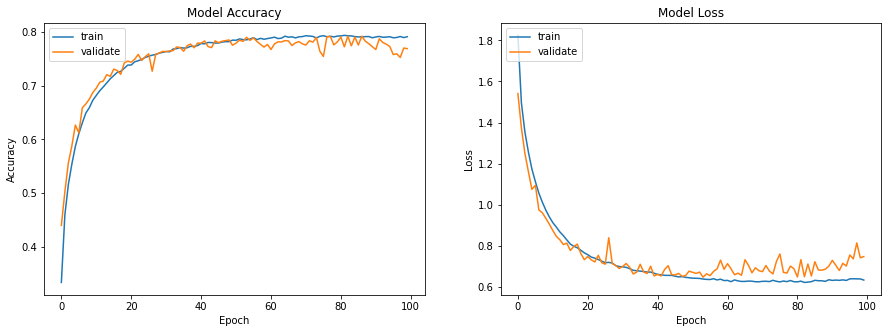

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7468 - accuracy: 0.7694
Test loss: 0.7468319535255432
Test accuracy: 0.7694000005722046


In [13]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model2.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model2.h5 
313/313 [==============================] - 2s 7ms/step - loss: 0.6198 - accuracy: 0.7879
Test loss: 0.619803786277771
Test accuracy: 0.7878999710083008
